## Mackey-Glass equation の Lyapunov exponents


### Makey-Glass equation

Blood productionのモデル。非線形のtime-delay differential equation。Time-delay $x(t-\tau)$のfeedbackがある分、見かけよりも自由度が大きい(厳密には無限自由度)。

\begin{equation}
\frac{d x(t)}{d t}=\frac{a x(t-\tau)}{1+x^{b}(t-\tau)}-c x(t)
\end{equation}

ここではKanno&Uchida PRE 2014にしたがって、$a=2$,、$b=10$、$c=1$、$\tau=5$とする。


In [1]:
using DifferentialEquations
using ForwardDiff
using LinearAlgebra
using Plots

In [2]:
# 問題の定義
using DifferentialEquations

# DifferentialEquations.jlでは、過去の履歴を指定するために、history function h(p, t)を使う。pはパラメータで、tは時間。
# これを指定すると、過去のsolutionを使ってtにおけるsolutionを内挿してくれる。
# 問題を定義するには、f(du, u, p, t)を拡張して、f(du, u, h, p, t)を使う。

function mackey_glass!(du, u, h, p, t)
 du[1] = 2.0*h(p, t-5)[1]/(1.0 + h(p, t-5)[1]^10) - 1.0*u[1]
end

mackey_glass! (generic function with 1 method)

In [3]:
# 自動微分でのJacobianの計算のために、delay coordinate h(p, t-tau)をu[2]として書き直す

function mackey_glass_for_jacobian!(du, u, p, t)
 du[1] = 2.0*u[2]/(1.0 + u[2]^10) - 1.0*u[1]
 du[2] = - 1.0*u[2]
end

mackey_glass_for_jacobian! (generic function with 1 method)

In [4]:
y = zeros(Float64, 2)
ForwardDiff.jacobian((du, u) -> mackey_glass_for_jacobian!(du, u, 0, 0), y, [0, 0])

2×2 Array{Float64,2}:
 -1.0   2.0
 -0.0  -1.0

In [5]:
lags = [5]

u0 = [0.5]
h(p, t) = ones(1)
tspan = (0.0, 100000.0)
#prob = ODEProblem(makey_glass!, u0, tspan)
prob = DDEProblem(mackey_glass!, u0, h, tspan; constant_lags=lags)


DDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100000.0)
u0: [0.5]

In [6]:
# 問題を解く

#alg = MethodOfSteps(Tsit5())
sol = solve(prob,Tsit5())
#sol = solve(prob, saveat=0.1) #0.1毎に解を保存する
#sol = solve(prob,save_everystep=false) #毎ステップ、解を保存する
#sol = solve(prob,alg_hints=[:stiff]) #問題がStiffであることを伝えて、ソルバーを選択してもらう
#sol = solve(prob,Tsit5()) #直接ソルバーを指定する Tsitouras 5/4 Runge-Kutta method

retcode: Success
Interpolation: Automatic order switching interpolation
t: 134835-element Array{Float64,1}:
      0.0                
      0.10003996803834632
      0.3452480702014222 
      0.6758286116796435 
      1.089665062846694  
      1.6031246633795115 
      2.221359161173539  
      2.9609844562010235 
      3.838311055317857  
      4.881990223755428  
      5.0                
      5.109512359178997  
      5.505823498619218  
      ⋮                  
  99991.30791580294      
  99992.11505639687      
  99992.81020182617      
  99993.62639535799      
  99994.41740340354      
  99995.0685955921       
  99995.81694464297      
  99996.64058281666      
  99997.47281102564      
  99998.24445453667      
  99999.41005185628      
 100000.0                
u: 134835-element Array{Array{Float64,1},1}:
 [0.5]     
 [0.547599]
 [0.645978]
 [0.745633]
 [0.831835]
 [0.899366]
 [0.945768]
 [0.974114]
 [0.989232]
 [0.996205]
 [0.99636] 
 [1.00213] 
 [1.08428] 
 ⋮         
 [0

In [10]:
M = 250;

u0 = zeros(Float64, (M+1, M+1));
for m = 1:(M+1)
    u0[m, m] = 1.0;
end

delta_t = 0.02
L_step = 500
L_time = delta_t * L_step
niterate = 100
r = zeros(Float64, M+1)
lyapunov_exponent = zeros(Float64, (niterate, M+1))

t = 0:delta_t:(M*delta_t)
for iiterate = 1:niterate
    for i = 1:L_step
        t = t .+ delta_t
        y = vec(sol(t))
        J = zeros(Float64, (M+1, M+1));
        J[1, 1] = 1.0 + delta_t.*(-1.0)
        for m = 2:(M+1)
            J[m, m-1] = 1.0;
        end
        dummy = zeros(Float64, (M+1, M+1))
        J[1, M+1] = delta_t .* ForwardDiff.jacobian((du, u) -> mackey_glass_for_jacobian!(du, u, 0, 0), dummy, [0, y[M+1]])[1, 2]
        u0 = J*u0
    end

    F = qr(u0)
    signR = diag(F.R) .< 0.0
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    for j in 1:(M+1)
        if signR[j]
            Q[:, j] .= Q[:, j] .* -1.0
            R[j, :] .= R[j, :] .* -1.0
        end
    end

    r = r .+ log.(diag(R))
    lyapunov_exponent[iiterate, :] .= r ./ (L_time*iiterate)
    u0 = Q
end

In [11]:
# 結果の値をチェックする
# maximum lyapunov exponent はおよそ 0.058
lyapunov_exponent[:, 1:10]

100×10 Array{Float64,2}:
 0.214902   -0.147369    -0.582751     …  -0.581804  -0.581698  -0.581618
 0.162574   -0.0446821   -0.22983         -0.655986  -0.658875  -0.661854
 0.151242   -0.0205335   -0.1588          -0.695861  -0.689133  -0.684073
 0.100819   -0.029994    -0.123616        -0.58866   -0.695777  -0.69678 
 0.0934744  -0.0261858   -0.100258        -0.527552  -0.590311  -0.626457
 0.0892825  -0.0173693   -0.0780719    …  -0.462998  -0.537182  -0.562683
 0.0769167  -0.0126807   -0.0684476       -0.43139   -0.495621  -0.522556
 0.0735549  -0.00358249  -0.0574844       -0.403879  -0.457213  -0.487813
 0.0669262   0.00297676  -0.0415609       -0.369849  -0.431541  -0.448706
 0.066169    0.0104048   -0.0384082       -0.341042  -0.405482  -0.422566
 0.0694465   0.00964973  -0.0315557    …  -0.324434  -0.390723  -0.402828
 0.0722404   0.0101223   -0.0260803       -0.310881  -0.380568  -0.387246
 0.0720275   0.0112428   -0.0255442       -0.301804  -0.370267  -0.376543
 ⋮           

---------

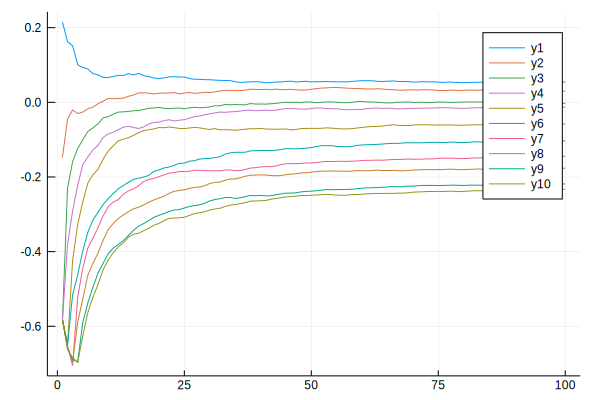

In [12]:
# 結果のプロット

plot(lyapunov_exponent[:, 1:10])